**Nome:** Riccardo <br>
**Cognome:** Confalonieri<br>
**Numero matricola:** 830404<br>
**E-mail:** r.confalonieri5@campus.unimib.it<br>
**A.A.** 2021-2022<br>

# **Digital Signal and Image Management - Assignment 5**<br/>
**Master's Degree in Data Science (A.Y. 2021/2022)**<br/>
**University of Milano - Bicocca**<br/>

Simone Bianco, Marco Buzzelli

## Descrizione
<p align = 'justify'>
Implementare il fine tuning di una rete preaddestrata per svolgere il task di classificazione sul dataset 101-object. In particolare si richiede di utilizzare un architettura differente da mobileNet e di sperimentare i risultati con operazioni di data augmentation.
<p/>

## Import packages

In [1]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Model
# per importare un dataset da google drive
import tarfile
from shutil import copyfile
# per collegarmi a google 
from google.colab import drive
# per plot e manipolazione dati
import matplotlib.pyplot as plt
import numpy as np

## Data loader
<p align = 'justify'>
Carico il dataset in formato .zip da google drive. Una volta estratto procedo con il caricamento attraverso un'apposita funzione di keras in quanto i dati sono caricati in diverse sottocartelle il cui nome corrisponde alle label delle immagini. 
</p>

In [2]:
# collegamento a drive
drive.mount('/content/drive', force_remount=True)

drive_path = '/content/drive/MyDrive/Colab Notebooks/DigitalSignal/Assignment/Assignment5/'

Mounted at /content/drive


In [3]:
# carico il dataset sulla macchina locale e lo scompatto nella root
copyfile(drive_path + '101_ObjectCategories_split.tar', '101_ObjectCategories_split.tar')
tar = tarfile.open('101_ObjectCategories_split.tar')
tar.extractall()
tar.close()

Carico le immagini di training e di test dalle rispettive cartelle.

In [4]:
# carico tutto il training set
train_set = keras.preprocessing.image_dataset_from_directory(
    # directory
    '101_ObjectCategories_split/train', 
    # estraggo in automatico le label
    labels = "inferred", label_mode = "categorical", 
    # se ci sono immagini non rgb vengono riconvertite, cosi non ho errori nel modello poi
    color_mode = "rgb",
    # cosi gli esempi non sono tutti in ordine
    shuffle = True, 
    # le immagini non hanno tutte la stessa dimensione e quindi devo forzarla (necessaria per la NN)
    image_size = (224,224), 
    batch_size = 32, 
    seed = 1
)

Found 4600 files belonging to 102 classes.


In [5]:
# carico tutto il test set
test_set = keras.preprocessing.image_dataset_from_directory(
    # directory
    '101_ObjectCategories_split/test', 
    # estraggo in automatico le label
    labels = "inferred", label_mode = "categorical", 
    # se ci sono immagini non rgb vengono riconvertite, cosi non ho errori nel modello poi
    color_mode = "rgb",
    # cosi gli esempi non sono tutti in ordine
    shuffle = True, 
    # le immagini non hanno tutte la stessa dimensione e quindi devo forzarla (necessaria per la NN)
    image_size = (224,224), 
    batch_size = 32, 
    seed = 1
)

Found 4544 files belonging to 102 classes.


In [6]:
# informazioni di base sul dataset
class_names = train_set.class_names

print('Tipo delle immagini:', type(train_set))
print('Numero di esempi di training:', len(train_set.file_paths))
print('Numero di classi:', len(class_names))
print("Dimensione dell'immagine: " + str(train_set.element_spec[0].shape[1:]))
print("Tipo dei valori dell'immagine: ", train_set.element_spec[0].dtype)
print('Numero di esempi di test:', len(test_set.file_paths))

Tipo delle immagini: <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Numero di esempi di training: 4600
Numero di classi: 102
Dimensione dell'immagine: (224, 224, 3)
Tipo dei valori dell'immagine:  <dtype: 'float32'>
Numero di esempi di test: 4544


<p align='justify'>
Il dataset caricato contiene $4600$ immagini di training e $4544$ per il test del modello. Ogni immagine ha una grandezza definita di $244x224$ per come è stato definito l'import dei dati, questa grandezza non è casuale è infatti uguale all'input che si aspetta il modello pretrainato scelto. Inoltre il dataset contiene $102$ differenti classi. <br>
Per verificare l'andamento del training decido di splittare il test set in due porzioni, una piccola porzione pari al $10\%$ la utilizzerò come validation set durante il training mentre la restante la utilizzerò per valutare le predizione del modello come se non conoscessi le reali label.
</p>


In [7]:
# get the dataset size as batch number
dataset_size = len(test_set.file_paths)/32
# get 10% as validation
val_size = int(0.10 * dataset_size)
# splitting
validation_set = test_set.take(val_size)
test_set = test_set.skip(val_size)  
# check size
print('Numero di esempi di validation:', tf.data.experimental.cardinality(validation_set).numpy()*32)
print('Numero di esempi di test:', tf.data.experimental.cardinality(test_set).numpy()*32)

Numero di esempi di validation: 448
Numero di esempi di test: 4096


Visualizzo quindi alcune possibili immagini con la rispettiva label.

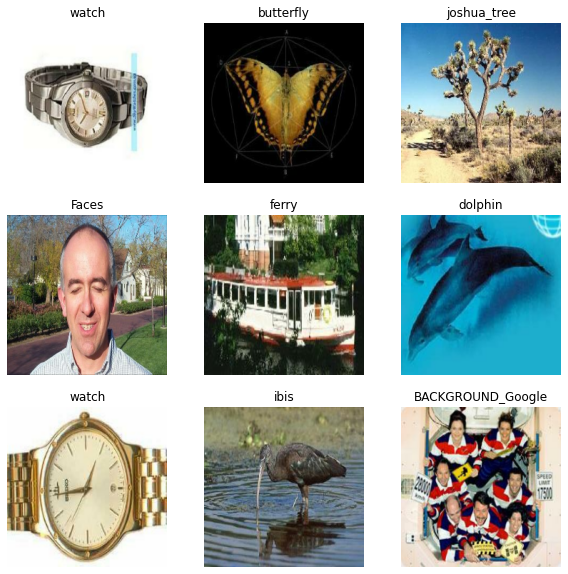

In [ ]:
plt.figure(figsize = (10,10))

# plot some examples
for images, labels in train_set.take(1):
  for i in range(9):
      ax = plt.subplot(3,3,i+1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[np.argmax(labels[i])])
      plt.axis("off")

## Import pretrained neural network (DenseNet121)
<p align='justify'>
Importo la rete neurale pretrainata, in questo caso ho deciso di utilizzare <i>DenseNet121</i> in quanto raggiunge una buona accuratezza sul task originale senza richiede un numero troppo elevato di parametri ed operazioni. <br>
</p>

In [ ]:
# definisco la shape del modello
train_shape = train_set.element_spec[0].shape
model_input_shape = (train_shape[1], train_shape[2], train_shape[3])

# carico la rete neurale pretrainata importando tutti i layer
base_net = keras.applications.DenseNet121(
    # uguale alla shape del train_set
    input_shape=model_input_shape,
    # utilizzo i pesi preaddestrati sul task di imagenet (default weights)
    weights="imagenet",
    # applica l'average pooling dopo i layer convoluzionalis
    pooling="max"
)

33202176/33188688 [==============================] - 0s 0us/step


In [ ]:
# Taglio dal modello l'ultimo layer fully connected in quanto non necessario per il task
base_net = Model(inputs=base_net.input, outputs=base_net.get_layer('avg_pool').output)
base_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
# visualizzo il numero di layer
print("Numero di layers", len(base_net.layers))

Numero di layers 428


In [ ]:
# Setto tutti i layer già presenti come non trainable cosi mantengo i pesi
for layer in base_net.layers:
  layer.trainable = False

## Model specialization
<p align='justify'>
Adatto il modello trainato su imagenet al particolare tipo di task che voglio affrontare. Nello specifico aggiungo due layer fully connected con rispettivamente $1024$ e $102$ neuroni, quest'ultimo mappa alla dimensione del task.
</p>

In [ ]:
# definisco la sequenza di operazioni del macro modello
inputs = keras.Input(shape=model_input_shape) # layer di input
x = inputs

# applico lo stesso preprocessing applicato all'input di mobileNetV2
x = keras.applications.densenet.preprocess_input(x)
# applico la rete di base (DenseNet121)
x = base_net(x)

# Aggiungo due semplici layer per la classificazione
x = keras.layers.Dense(1024, activation = "relu")(x)
# layer che mappa al numero di classi del nostro problema
x = keras.layers.Dense(102, activation = "softmax")(x)

outputs = x

In [ ]:
# definisco il macro modello
model1 = keras.Model(inputs=inputs, outputs=outputs)

# compilo il modello utilizzando rmsprop come funzione di ottimizzazione
model1.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.0001), 
               loss="categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
# fitto il modello, il batch_size è già specificato intrinsecamente nel data loader
history = model1.fit(train_set, epochs = 15, validation_data = validation_set)

Epoch 1/15
144/144 [==============================] - 57s 345ms/step - loss: 2.7220 - accuracy: 0.4522 - val_loss: 1.6686 - val_accuracy: 0.7076
Epoch 2/15
144/144 [==============================] - 48s 330ms/step - loss: 1.0368 - accuracy: 0.8226 - val_loss: 0.7727 - val_accuracy: 0.8728
Epoch 3/15
144/144 [==============================] - 48s 330ms/step - loss: 0.4745 - accuracy: 0.9180 - val_loss: 0.4790 - val_accuracy: 0.8929
Epoch 4/15
144/144 [==============================] - 48s 329ms/step - loss: 0.2819 - accuracy: 0.9470 - val_loss: 0.4048 - val_accuracy: 0.9018
Epoch 5/15
144/144 [==============================] - 48s 330ms/step - loss: 0.1874 - accuracy: 0.9685 - val_loss: 0.3276 - val_accuracy: 0.9152
Epoch 6/15
144/144 [==============================] - 48s 330ms/step - loss: 0.1282 - accuracy: 0.9809 - val_loss: 0.2960 - val_accuracy: 0.9174
Epoch 7/15
144/144 [==============================] - 48s 330ms/step - loss: 0.0950 - accuracy: 0.9872 - val_loss: 0.3110 - val_ac

In [ ]:
# Funzione che visualizza la storia di training del modello
def plot_history(network_history):
    plt.figure(figsize = (10, 6))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(np.arange(len(network_history.epoch)), np.arange(1, len(network_history.epoch)+1))
    plt.title('model loss')
    plt.plot(network_history.history['loss'], marker='.')
    plt.plot(network_history.history['val_loss'], marker='.')
    plt.legend(['Training', 'Validation'])

    plt.figure(figsize = (10, 6))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(len(network_history.epoch)), np.arange(1, len(network_history.epoch)+1))
    plt.title('model accuracy')
    plt.plot(network_history.history['accuracy'], marker='.')
    plt.plot(network_history.history['val_accuracy'], marker='.')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

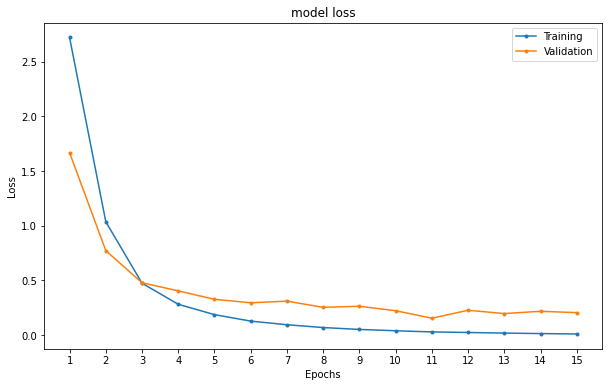

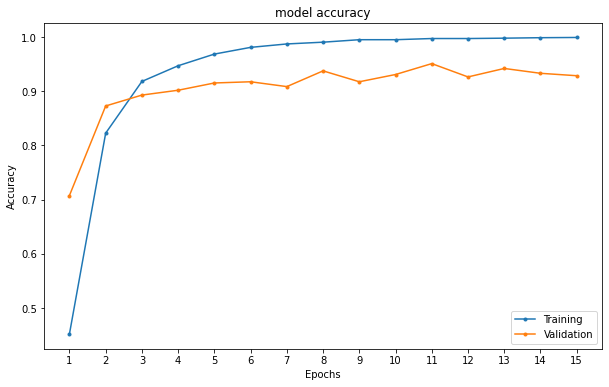

In [ ]:
plot_history(history)

<p align='justify'>
Il modello è stato trainato utilizzando come funzione di ottimizzazione rmsprop e settando come epoche massime $15$. Come si può notare dal grafico sopra riportato nonostante il modello raggiunga score elevati, sia sul training che sul test, risulta evidente la presenza di overfitting già a partire dalla terza epoca. Sono state provate anche altre configurazioni che però peggioravano ulteriormente l'overfitting, per questo motivo si è tornati alla configurazione base proposta durante l'esercitazione di laboratorio.
</p>

### Model evaluation
<p align='justify'>
Utilizzo il modello appena addestrato per predire le classi di appartenenza delle immagini presenti nel test set. Avendo splittato inizialmente questo dataset in due parti, per ottenere un validation set, mi aspetto che i valori di loss e accuracy raggiunti per la classificazione delle nuove immagini siano molto simili a quelle ottenute in fase di training con il validation set. 
</p>

In [ ]:
# valuto il modello sul test set 
prediction_result = model1.evaluate(test_set)

print('Loss sul test set:', prediction_result[0])
print('Accuracy sul test set:', prediction_result[1])

128/128 [==============================] - 39s 297ms/step - loss: 0.2481 - accuracy: 0.9329
Loss sul test set: 0.2480536848306656
Accuracy sul test set: 0.932861328125


<p align='justify'>
I risultati sono in linea con quanto raggiunto dal validation durante il training per quanto riguarda l'accuracy, mentre la loss risulta essere inferiore a quanto visto precedentemente. 
</p>

### Model specialization with data augmentation
<p align='justify'>
Data la forte presenza di overfitting provo ad introdurre dei layer di data augmentation per cercare di risolvere questa problematica. <br>
Si sono aggiunti i seguenti layer:


*   <b>Random zoom</b>. In cui si effettua un zoomed out  di $0.1$ per l'altezza e $0.15$ per la largezza.
*   <b>Random rotation</b>. In cui si ruota in senso orario l'immagine di un fattore pari a $0.45$
*   <b>Random contrast</b>. Con il quale il contrasto dell'immagine viene scalato di un fattore $0.2$

Tutte queste operazioni di data augmentation sono <i>effettuate soltanto durante la fase di training</i>, mentre non vengono applicate durante l'inferenza.
</p>

In [ ]:
# definisco la sequenza di operazioni del macro modello
inputs = keras.Input(shape=model_input_shape) # layer di input
x = inputs

# Applico DATA AUGMENTATION
x = keras.layers.RandomZoom(0.1, 0.15)(x)
# rotazione con rotazione di max 0.45 in senso orario
x = keras.layers.RandomRotation(0.45)(x)
# correzione del contrasto dell'immagine, viene eseguita indipendentemente per ognuno dei 3 canali rgb
x = keras.layers.RandomContrast(0.2)(x)

# applico lo stesso preprocessing applicato all'input di mobileNetV2
x = keras.applications.densenet.preprocess_input(x)
# applico la rete di base (DenseNet121)
x = base_net(x)

# Aggiungo due semplici layer per la classificazione
x = keras.layers.Dense(1024, activation = "relu")(x)
# layer che mappa al numero di classi del nostro problema
x = keras.layers.Dense(102, activation = "softmax")(x)

outputs = x

In [ ]:
# definisco il macro modello
model2 = keras.Model(inputs=inputs, outputs=outputs)

# compilo il modello utilizzando rmsprop come funzione di ottimizzazione
model2.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.0001), 
               loss="categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
# fitto il modello, il batch_size è già specificato intrinsecamente nel data loader
history2 = model2.fit(train_set, epochs = 15, validation_data = validation_set)

Epoch 1/15
144/144 [==============================] - 61s 298ms/step - loss: 3.1135 - accuracy: 0.3407 - val_loss: 2.3069 - val_accuracy: 0.5089
Epoch 2/15
144/144 [==============================] - 40s 272ms/step - loss: 1.7802 - accuracy: 0.6209 - val_loss: 1.4141 - val_accuracy: 0.6987
Epoch 3/15
144/144 [==============================] - 39s 272ms/step - loss: 1.1511 - accuracy: 0.7509 - val_loss: 0.9681 - val_accuracy: 0.7969
Epoch 4/15
144/144 [==============================] - 39s 271ms/step - loss: 0.8314 - accuracy: 0.8183 - val_loss: 0.7231 - val_accuracy: 0.8281
Epoch 5/15
144/144 [==============================] - 39s 271ms/step - loss: 0.6654 - accuracy: 0.8467 - val_loss: 0.6299 - val_accuracy: 0.8482
Epoch 6/15
144/144 [==============================] - 39s 271ms/step - loss: 0.5686 - accuracy: 0.8635 - val_loss: 0.6830 - val_accuracy: 0.8214
Epoch 7/15
144/144 [==============================] - 39s 271ms/step - loss: 0.4883 - accuracy: 0.8815 - val_loss: 0.5599 - val_ac

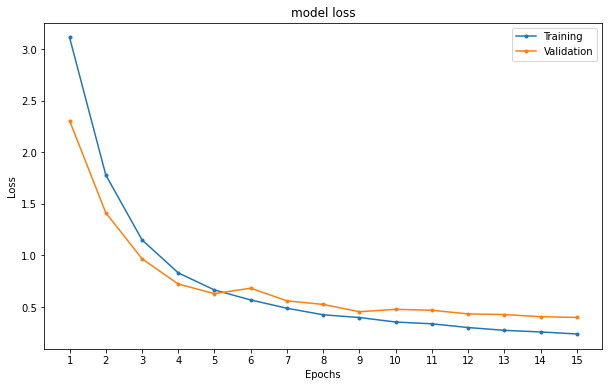

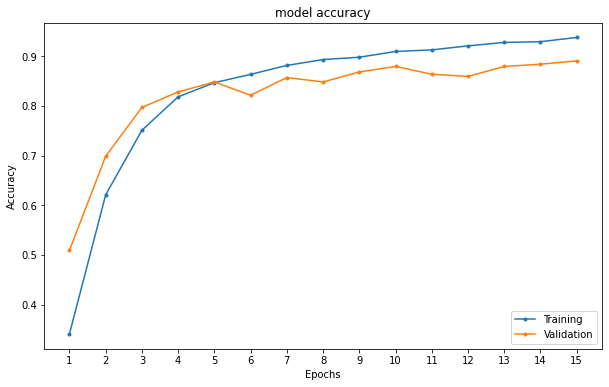

In [ ]:
plot_history(history2)

In [ ]:
# valuto il modello sul test set 
prediction_result = model2.evaluate(test_set)

print('Loss sul test set:', prediction_result[0])
print('Accuracy sul test set:', prediction_result[1])

128/128 [==============================] - 31s 236ms/step - loss: 0.3860 - accuracy: 0.8940
Loss sul test set: 0.3859812617301941
Accuracy sul test set: 0.89404296875


<p align='justify'>
In questo caso possiamo notare che si ha una leggera perdita di accuratezza misurata sul test set rispetto al modello senza data augmentation. Tuttavia il grafico che riporta l'andamento del training mostra un miglioramento rispetto alla problematica dell'overfitting presentatasi in precedenza. <br>
Durante lo sviluppo dell'esericizio si sono provati anche altri tipo di data augmentation, come il rescaling di altezza e/o larghezza, che però non portavano a risultati migliori e sono stati quindi scartati per il notevole tempo computazionale aggiuntivo che richiedevano durante il training.
</p>

### Data augmentation v2
<p align='justify'>
I risultati ottenuti con la prima versione di data augmentation sono riusciti a mitigare in parte l'overfitting. Tuttavia durante l'implementazione si è notato che cambiando leggermente gli iperparametri dei layer di augmentation i risultati variano velocmente. Ad esempio nella seguente sezione si riporta una configurazione con parametri leggermente diversi che permette di ottenere comunque ottimi score e di ridurre ulteriormente l'overfitting del modello.
</p>

In [ ]:
# definisco la sequenza di operazioni del macro modello
inputs = keras.Input(shape=model_input_shape) # layer di input
x = inputs

# Applico DATA AUGMENTATION
x = keras.layers.RandomZoom(0.3, 0.3)(x)
# rotazione con rotazione di max 0.45 in senso orario
x = keras.layers.RandomRotation(0.45)(x)
# correzione del contrasto dell'immagine, viene eseguita indipendentemente per ognuno dei 3 canali rgb
x = keras.layers.RandomContrast(0.25)(x)

# applico lo stesso preprocessing applicato all'input di mobileNetV2
x = keras.applications.densenet.preprocess_input(x)
# applico la rete di base (DenseNet121)
x = base_net(x)

# Aggiungo due semplici layer per la classificazione
x = keras.layers.Dense(1024, activation = "relu")(x)
# layer che mappa al numero di classi del nostro problema
x = keras.layers.Dense(102, activation = "softmax")(x)

outputs = x

In [ ]:
# definisco il macro modello
model3 = keras.Model(inputs=inputs, outputs=outputs)

# compilo il modello utilizzando rmsprop come funzione di ottimizzazione
model3.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.0001), 
               loss="categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
# fitto il modello, il batch_size è già specificato intrinsecamente nel data loader
history3 = model3.fit(train_set, epochs = 15, validation_data = validation_set)

Epoch 1/15
144/144 [==============================] - 50s 286ms/step - loss: 3.1618 - accuracy: 0.3411 - val_loss: 2.3116 - val_accuracy: 0.5424
Epoch 2/15
144/144 [==============================] - 39s 270ms/step - loss: 1.8498 - accuracy: 0.6039 - val_loss: 1.4355 - val_accuracy: 0.7031
Epoch 3/15
144/144 [==============================] - 39s 271ms/step - loss: 1.2498 - accuracy: 0.7243 - val_loss: 0.9426 - val_accuracy: 0.7991
Epoch 4/15
144/144 [==============================] - 39s 270ms/step - loss: 0.9338 - accuracy: 0.7839 - val_loss: 0.7755 - val_accuracy: 0.8125
Epoch 5/15
144/144 [==============================] - 39s 271ms/step - loss: 0.7601 - accuracy: 0.8220 - val_loss: 0.6459 - val_accuracy: 0.8259
Epoch 6/15
144/144 [==============================] - 39s 272ms/step - loss: 0.6505 - accuracy: 0.8387 - val_loss: 0.6065 - val_accuracy: 0.8415
Epoch 7/15
144/144 [==============================] - 39s 272ms/step - loss: 0.5727 - accuracy: 0.8607 - val_loss: 0.5153 - val_ac

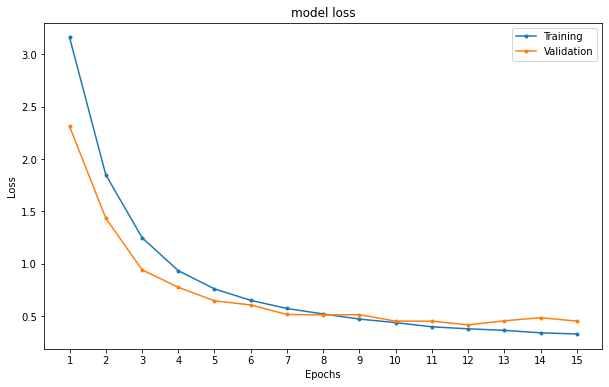

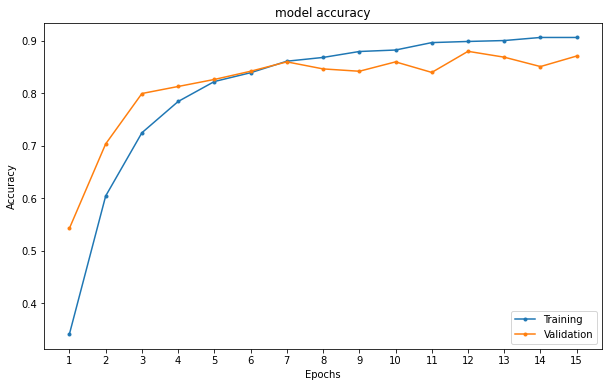

In [ ]:
plot_history(history3)

In [ ]:
# valuto il modello sul test set 
prediction_result = model3.evaluate(test_set)

print('Loss sul test set:', prediction_result[0])
print('Accuracy sul test set:', prediction_result[1])

128/128 [==============================] - 31s 236ms/step - loss: 0.4208 - accuracy: 0.8828
Loss sul test set: 0.42079904675483704
Accuracy sul test set: 0.8828125


<p align='justify'>
Come si può vedere in questo caso l'accuracy è equivalente alla prima versione con layer di data augmentation, tuttavia l'overfitting è ridotto ulteriormente e se ci riferiamo alla loss è ristretto solamente alle ultime $3/4$ epoche a differenza di prima. <br>
Tuttavia come anticipato anche piccoli cambiamenti negli iperparametri dei layer di augmentation potrebbero variare significativamente sia l'andamento dei grafici sia lo score finale. Si ritiene che questa possa essere comunque una configurazione valida, eventualmente introducendo altre tecniche come l'early stopping per prevenire ulteriormente l'overfitting.
</p>

In [ ]:
%%shell
jupyter nbconvert --to html '/content/drive/MyDrive/Colab Notebooks/DigitalSignal/Assignment/Assignment5/DSIM_Assignment5.ipynb'